![Electronics circuit board near tester (Nicolas Thomas)](./nicolas-thomas-3GZi6OpSDcY-unsplash.jpg)

This post will be a deep dive into word embeddings. Word embeddings have made multiple appearances on this blog, such as in my [talk about neural networks](https://fohlen.github.io/posts/are-neural-networks-all-you-need/Are_neural_networks_all_you_need.html), or [the spaCy benchmark](https://fohlen.github.io/posts/missing-spacy-benchmark/Missing_spaCy_benchmark.html). The reason I am captivated by word embeddings is threefold:

- they are very useful, the underlying building blocks for most text-based machine learning models
- word embeddings are computationally efficient (you can encode _"all the language's meaning"_ in a few hundred megabyte)
- very few people actually understand what the consequences of embeddings are

Cosine similarity is the most popular method to date to compare embeddings (such as in document retrieval). A recent paper by [@steck2024cosine] investigated the usage of cosine similarity and uncovered some surprising findings:

> We study cosine similarities in the context of linear matrix factorization models, which allow for analytical derivations, and show that cosine similarities are heavily dependent on the method and regularization technique, and in some cases can be rendered even meaningless.

The de-facto industry standard method doesn't really work? It seems counterintuitive. 

From my experience on working on retrieval augmented generation, I would say that does check out. Cosine similarity does convey a sense of similarity, but often times results are very counterintuitive. 

To corroborate these suspicions, I thought it would be interesting to investigate two popular word embedding models:

1. GloVe: Global Vectors for Word Representation [@pennington2014glove]
2. Word2Vec [@bojanowski2016enriching]

## Making assumptions

To start an investigation, some assumptions will need to be made:

1. for vocabulary of size $N$, word embeddings should project a matrix of size $N \times N$
2. for every item in the matrix, the cosine distance should be $\{-1, ..., 1\} \in ℝ$
3. thus, the expected mean of all embeddings should be $0$

With these assumptions at hand, the next step is to obtain the embeddings we want to experiment with.
GloVe vectors can be downloaded right [from the Stanford website](https://nlp.stanford.edu/projects/glove/). They are stored in a simple format. Each line contains one word, and a list of floating point numbers seperated by space. For the word _"the"_ this looks like so:

```shell
the 0.04656 0.21318 -0.0074364 -0.45854 ...
```

One can download pre-trained word2vec vectors [from the fasttext website](https://fasttext.cc/docs/en/english-vectors.html). However, they are not of the same format as GloVe, thus we should convert them to be more usable. We can do this with a few simple lines of Python:

```python
import argparse
from pathlib import Path

from fasttext import FastText
import fasttext.util
from tqdm import tqdm


def write_model(output_file: Path, model: FastText):
    with output_file.open("wt") as fp:
        for word in tqdm(model.words):
            line_elements = [word] + [str(num) for num in ft.get_word_vector(word)]
            line = " ".join(line_elements)
            print(line, file=fp)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("output_file", type=Path)
    args = parser.parse_args()
    
    ft = fasttext.load_model('cc.en.300.bin')
    write_model(args.output_file, ft)
```

## Calculating a similarity matrix

Next, we want to calculate a similarity matrix for our words:

$\forall word_1, word_2 \in vector: cos(word_1, word_2)$

While theoretically simple, it turns out to be a non-trivial undertaking. Using simple multiplication we find the storage requirement for our embeddings to be:

- for GloVe, $400000^2 * 4 / 10^{9} = 640 GB$
- for fasttext, $1000000^2 * 4 / 10^{11} = 4 TB$

Simply saving the similarity matrices will require $4.6$ terabyte of storage. Not ideal for a small experiment. Beyond storage space, we need to keep the runtime complexity in check. [@Wenkel_2024] wrote a fast version of cosine distance in Rust, which we we will lend for this blog post:


```rust
pub fn cosine_dist_rust_loop_vec(vec_a: &[f64], vec_b: &[f64], vec_size: &i64) -> f64
{
    let mut a_dot_b:f64 = 0.0;
    let mut a_mag:f64 = 0.0;
    let mut b_mag:f64 = 0.0;

    for i in 0..*vec_size as usize
    {
        a_dot_b += vec_a[i] * vec_b[i];
        a_mag += vec_a[i] * vec_a[i];
        b_mag += vec_b[i] * vec_b[i];
    }

    let dist:f64 = 1.0 - (a_dot_b / (a_mag.sqrt() * b_mag.sqrt()));

    return dist
}
```

Thus, for every word, we will perform $D*3 + 1$ multiplications where $D$ is the dimensions of the vector. We will conclude that the runtime complexity of calculating the full similarity matrix is $O(3N*D^2)$ operations (for the sake of argument, the other operations are negligible). This means:

- GloVe will require $(3*300*400000)^2 = 1.296*10^{17}$ multiplications
- fasttext will require $(3*300*1000000)^2 = 8.1*10^{17}$ multiplications


Which is a significant amount of operations. This should be an obvious reason why embeddings are not stored as similarity matrices. For the sake of simplicity, we will sample $0.5\%$ of these similarities. For GloVe we will reduce our sample vocabulary to $20000$ , whereas for fasttext it will be reduced to $50000$ words. 

Now, we can piece together a simple Rust program to calculate the cosine similarities for us. To do so, first we load the model into memory:

```rust
use std::collections::HashMap;
use std::fs::File;
use std::io::{BufRead, BufReader};
use std::path::Path;

pub type Embedding = HashMap<String, Vec<f64>>;


pub fn load_model(input_file: &Path) -> Result<Embedding, std::io::Error> {
    let mut model = HashMap::new();
    let file = File::open(input_file)?;
    let reader = BufReader::new(file);

    for line in reader.lines() {
        let line = line?;
        let items: Vec<String> = line.split_whitespace().map(|s| s.to_string()).collect();
        let word = items[0].clone();
        let embedding: Vec<f64> = items[1..]
            .iter()
            .map(|s| s.parse::<f64>())
            .collect::<Result<Vec<_>, _>>().unwrap();
        model.insert(word, embedding);
    }

    Ok(model)
}
```

Our `load_model` function returns a hashmap of every word to its respective vector. 

Finally, we piece together our main function. It will iterate through all words in our hashmap, and write each distance to a file:

```rust
use std::fs::{OpenOptions};
use std::io::{LineWriter, Write};
use std::path::{Path, PathBuf};
use tqdm::pbar;
use embedding_network::{cosine_dist_rust_loop_vec, load_model};


fn write_distances(model_path: &Path, output_path: &Path) {
    let model = load_model(model_path).unwrap();
    let mut pbar = pbar(Some(model.len() * model.len()));
    let file = OpenOptions::new()
        .write(true)
        .create(true)
        .open(output_path).unwrap();
    let mut writer = LineWriter::new(file);

    for (_, vec1) in &model {
        for (_, vec2) in &model {
            pbar.update(1).unwrap();
            let distance = cosine_dist_rust_loop_vec(
                vec1,
                vec2,
                &(vec1.len() as i64)
            );

            writer.write_fmt(format_args!("{}\n", distance)).unwrap();
        }
    }

    writer.flush().unwrap();
}


struct Cli {
    input: PathBuf,
    output: PathBuf,
}

fn main() {
    let input_path = std::env::args().nth(1).expect("no input path given");
    let output_path = std::env::args().nth(2).expect("no output path given");

    let args = Cli {
        input: PathBuf::from(input_path),
        output: PathBuf::from(output_path),
    };

    write_distances(args.input.as_path(), args.output.as_path());
}
```

A full copy of the program is [attached to this blog post](./embedding_network/src/bin/distances.rs).

## Evaluating distances

Once we calculated the distances, we can read them out and plot a histogram. Since we have a lot of data, a simple `plt.hist()` would be really slow. Instead, we cumulate our data into a histogram:

In [1]:
import numpy as np
from more_itertools import batched

def calculate_hist(file_name: str, chunk_size=100000, num_bins=100):
    # Initialize empty arrays to store cumulative counts and bins
    cumulative_counts = np.zeros(num_bins)
    counts, bins = None, None
    
    with open(file_name) as fp:
        # Loop through the data in chunks
        for lines in batched(fp, chunk_size):
            distances = [float(line.strip()) for line in lines]
    
            counts, bins = np.histogram(distances, bins=num_bins)
            cumulative_counts += counts

    return counts, bins

In [3]:
counts_glove, bins_glove = calculate_hist("/Users/fohlen/RustRoverProjects/embedding_network/glove.6B.300d.distances.txt")
counts_fasttext, bins_fasttext = calculate_hist("/Users/fohlen/RustRoverProjects/embedding_network/cc.en.300.distances.txt")

Finally, we can plot our histogram:

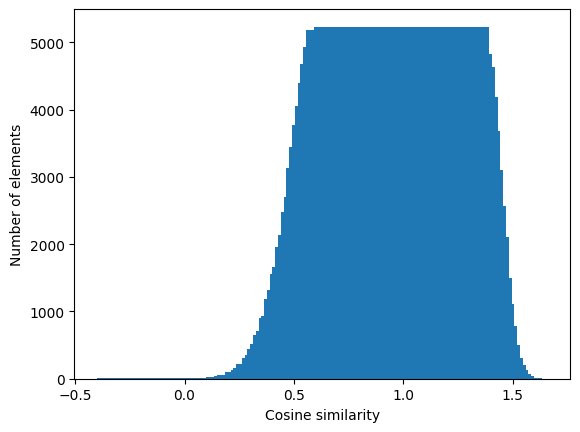

In [4]:
import matplotlib.pyplot as plt

#| label: fig-hist-cosine-distance-glove
#| fig-cap: "Histogram of distances in GloVe 300d"

# Plot the histogram as bars
plt.bar(bins_glove[:-1], counts_glove)  # Use bins[:-1] to avoid plotting the upper bin edge twice

plt.xlabel("Cosine similarity")
plt.ylabel("Number of elements")

# Display the plot
plt.show()

We repeat the same steps for our fasttext embeddings:

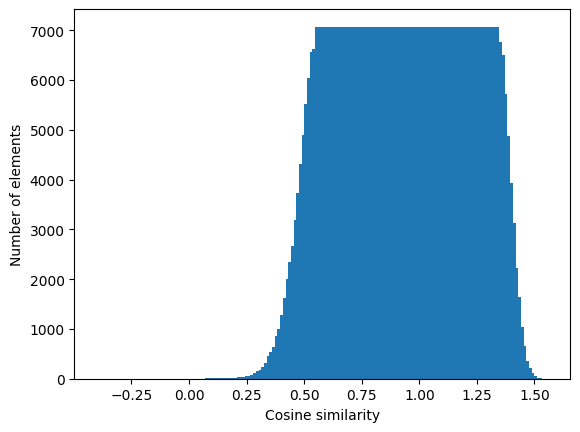

In [6]:
import matplotlib.pyplot as plt

#| label: fig-hist-cosine-distance-fasttext
#| fig-cap: "Histogram of distances in fasttext 300d"

# Plot the histogram as bars
plt.bar(bins_fasttext[:-1], counts_fasttext)  # Use bins[:-1] to avoid plotting the upper bin edge twice

plt.xlabel("Cosine similarity")
plt.ylabel("Number of elements")

# Display the plot
plt.show()

## Results

We can see that our assumptions do not hold up, as:

- cosine similarity is a normal distribution with mean of $\approx 1.0$
- cosine similarities are practically never negative
- thus, the sum of all distances is not zero

This confirms [@steck2024cosine] findings, and has some surprising implications. Using cosine similarity, the distance to other items in the vocabulary is not unique or idempotent. This means, the famed equality:

$king - man + woman = queen$

Is unlikely to hold up. This suspicion had been stated by [@Jurafsky2008-yj] before:

> Furthermore while embedding spaces perform well if the task involves frequent words, small distances, and certain relations (like relating countries with their capitals or verbs/nouns with their inflected forms), the parallelogram method with embeddings doesn’t work as well for other relations (Linzen 2016, Gladkova et al. 2016, Schluter 2018, Ethayarajh et al. 2019a)

This should caution us from blindly trusting cosine similarity in recommendations systems. There are multiple ideas to improve the results of cosine similarity. [@steck2024cosine] suggest to tune regularization correctly to fit better to cosine similarity. However, in industry we often times do not create our own embeddings (as it is very time consuming), thus we have little influence over the regularization process. Another route to explore is two-stage learning (for information retrieval) and reranking, as detailed by [@10.1007/978-3-642-36973-5_36]. Ultimatively, this pilot experiment should caution users to rely solely on one distance metric when building retrieval systems.